In [36]:
### creating anime recommendation based on user's watch history and the similarity between animes ###

In [37]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import traceback
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import KFold
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split, cross_val_score
from IPython.display import display
from sklearn.metrics import silhouette_score, silhouette_samples
from mlxtend.preprocessing import TransactionEncoder

In [38]:
### importing data ###

In [39]:
# anime dataframe - the dataset contains 12,294 rows, one for each anime
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [40]:
# the user dataframe contains 7,813,737 rows, each row with each user's watched anime
user_df = pd.read_csv('rating.csv')
user_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [41]:
### analyzing the data ###

In [42]:
# null values in anime_df
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [43]:
# null values in user_df
user_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [44]:
# lets look into the 'type' column

# return the unique types of anime
anime_df['type'].unique()

# note: there is both 'Music' and 'NULL' types - lets check them out

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

In [45]:
# return all whose type is null - 25 rows
null_type = anime_df[anime_df['type'].isnull()]
null_type.head()

# note: those with null types also have 'Unknown' episodes and NULL ratings
# note: we should consider 'Unknown' episodes as NULL

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,NaN,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,NaN,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,NaN,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,NaN,8666


In [46]:
# return all whose type is 'Music' - 488 rows
music_type = anime_df[anime_df['type']=='Music']
music_type.head()
# note: after looking into these, I've confirmed that 'Music' type is not anime, but actually Music. These will be removed.

,anime_id,name,genre,type,episodes,rating,members
169,34240,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
336,731,Interstella5555: The 5tory of The 5ecret 5tar ...,"Adventure, Drama, Music, Sci-Fi",Music,1,8.17,31464
533,17949,The Everlasting Guilty Crown,Music,Music,1,8.00,11663
1178,2768,CLAMP in Wonderland 2,"Action, Comedy, Drama, Fantasy, Magic, Music, ...",Music,1,7.64,13985
1267,9930,Snow Halation,Music,Music,1,7.61,8731


In [47]:
# return all the anime_id of null type
null_type_animeID = null_type['anime_id'].tolist()
#print(null_type_animeID)

In [48]:
# return all the anime_id of music type
music_animeID = music_type['anime_id'].tolist()
#print(music_animeID)

In [49]:
# remove music and null type from anime_df
anime_df.drop(anime_df.loc[anime_df['type']=='Music'].index, inplace=True)
anime_df.drop(anime_df.loc[anime_df['type'].isnull()].index, inplace=True)

# remove music and null types from user_df
user_df = user_df[~user_df.anime_id.isin(null_type_animeID)]
user_df = user_df[~user_df.anime_id.isin(music_animeID)]

# note: once this is done, we are left with only anime in anime_df

In [50]:
# lets look into 'rating' column

# getting the rating of each anime
anime_rating = anime_df.rating.copy()

# return the ratings that are null - 205 rows
null_rating = anime_df[anime_rating.isnull()]
null_rating.head()

# note: notice that of the anime with NULL ratings, there are 'Unknown' episodes. Lets inspect this.

,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10899,25777,Shingeki no Kyojin Season 2,"Action, Drama, Fantasy, Shounen, Super Power",TV,Unknown,NaN,170054


In [51]:
# getting episodes of anime that are 'Unknown' - 314 rows
anime_df[anime_df.episodes == 'Unknown'].head()

# note: some anime with 'Unknown' episodes have large amount of members
# ex: anime_id = 21, name = One Piece, members = 504862
# therefore, anime with 'Unknown' episodes cannot be outright removed

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,Unknown,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,Unknown,7.73,26267
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,Unknown,7.72,5400


In [52]:
# getting episodes of anime with NULL ratings
null_rating_anime_episodes = null_rating.episodes.copy()

# returning those with null ratings AND null episodes - 127 rows
null_episode_rating = null_rating[null_rating_anime_episodes == 'Unknown']
null_episode_rating.head()

# note: of the 205 anime with NULL ratings, 127 have 'Unknown' episodes. 
# this may mean that this anime may not exist or has not been released
# we know that if there is no rating, there is no views, so we can remove anime with null ratings

,anime_id,name,genre,type,episodes,rating,members
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10899,25777,Shingeki no Kyojin Season 2,"Action, Drama, Fantasy, Shounen, Super Power",TV,Unknown,NaN,170054
10901,33486,Boku no Hero Academia 2nd Season,"Action, Comedy, School, Shounen, Super Power",TV,Unknown,NaN,46892


In [53]:
# return all whose rating is null - 205 rows
null_rating = anime_df[anime_df['rating'].isnull()]
null_rating.head()

,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10899,25777,Shingeki no Kyojin Season 2,"Action, Drama, Fantasy, Shounen, Super Power",TV,Unknown,NaN,170054


In [54]:
# return all the anime_id of null ratings
null_rating_animeID = null_rating['anime_id'].tolist()
#print(null_animeID)

In [55]:
# remove anime with null ratings from anime_df
anime_df = anime_df[~ anime_df.rating.isnull()]

# remove anime with null ratings from user_df
user_df = user_df[~user_df.anime_id.isin(null_rating_animeID)]

In [56]:
# now lets look into the 'members' column
# note: I will not use the 'members' column for my model, but lets get an insight on what we should be expecting

members = anime_df.sort_values(by='members', ascending=False)
members.head()

# note: we see that the anime with the most members is 'Death Note', which may indicate that it'll be recommended more

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796


In [57]:
# now lets look into the 'name' column
# note: since I will make my models based on 'anime_id' rather than 'name', I don't believe I'll be needing to clean this data
# but, lets take a look into the data

anime_df.head()

# note: just from the first 5 data, we see two 'Gintama'
# however, although they have very similar genre, episodes, rating, and members, they have two different anime_id
# I will keep both of these 'Gintama' since in the users_df their anime_id might be referenced. I don't want to lose this info.

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [58]:
# animes whose names have been duplicated
anime_df.name[anime_df.name.duplicated()]

10141           Saru Kani Gassen
10194    Shi Wan Ge Leng Xiaohua
Name: name, dtype: object

In [59]:
# lets look into these duplicated anime names
# note: for the same reason as before, I will keep both of these instances of duplicated anime
display(anime_df[anime_df.name == 'Saru Kani Gassen'])
display(anime_df[anime_df.name == 'Shi Wan Ge Leng Xiaohua'])

,anime_id,name,genre,type,episodes,rating,members
10140,22399,Saru Kani Gassen,Kids,OVA,1,5.23,62
10141,30059,Saru Kani Gassen,Drama,Movie,1,4.75,76


,anime_id,name,genre,type,episodes,rating,members
10193,33193,Shi Wan Ge Leng Xiaohua,"Comedy, Parody",ONA,12,6.67,114
10194,33195,Shi Wan Ge Leng Xiaohua,"Action, Adventure, Comedy, Fantasy, Parody",Movie,1,7.07,110


In [60]:
### analyzing the genres - this will be a key attribute for our model ###

In [61]:
# get the anime with null genre - 47 rows
anime_df[anime_df.genre.isnull()].head()

# note: there are anime with null genre, however, this should not be neglected and removed
# instead, we can look into the genre and one-hot encode them
# those with null genre will have [0,0,..., 0] for all genre columns

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607


In [62]:
# getting the genre of each anime
animes_genre = anime_df.genre.copy()

# analysis on genre column, they need to be split using one-hot encoding
animes_genre.value_counts()

Hentai                                                                          816
Comedy                                                                          521
Kids                                                                            197
Comedy, Slice of Life                                                           174
Dementia                                                                        137
                                                                               ... 
Action, Drama, Ecchi, Harem, Martial Arts, Military, Romance, Sci-Fi, Seinen      1
Adventure, Drama, Sci-Fi, Shounen                                                 1
Action, Comedy, Fantasy, Mystery, Shounen Ai, Supernatural, Vampire               1
Action, Comedy, Magic, Sci-Fi, Super Power                                        1
Hentai, Slice of Life                                                             1
Name: genre, Length: 3180, dtype: int64

In [63]:
# get all genre within genre column separate them into different columns
# each row is an animeID where they will have 0 (no) or 1 (yes) for their genre

def handle_genre(genre_col):
    
    genres = []
    
    # extract all genres of Anime, duplicated genres
    for genre in genre_col:
        genres.extend(str(genre).strip()\
                      .replace(', ', ',').replace(' ,', ',').upper().split(','))
        pass
    
    genres = np.unique(genres) # get only the unique genres
    print(f"Number of Unique \033[1mGenres\033[0m is {len(genres)}")
    
    # Make Dataframe contains 
       # unique genres as columns
       # animes (animeID) as rows
       # Do the anime genres contain this genres as cell-value
    # i.e, Make Dummy Feature 
    data_frame = pd.DataFrame(columns=genres, index= genre_col.index).fillna(0)
    
    # Fill Dataframe { 1:genre-included, 0:not-included}
    for ind in genre_col.index:
        for gen in str(genre_col.loc[ind]).strip()\
                      .replace(', ', ',').replace(' ,', ',').upper().split(','): 
            data_frame.loc[ind][gen] = 1
            pass
        pass
    return data_frame

In [64]:
# get the anime genres and separate them into their own columns - 44 different genres
genres = handle_genre(anime_df.genre.copy())
genres.head(5)

Number of Unique Genres is 44


,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,GAME,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


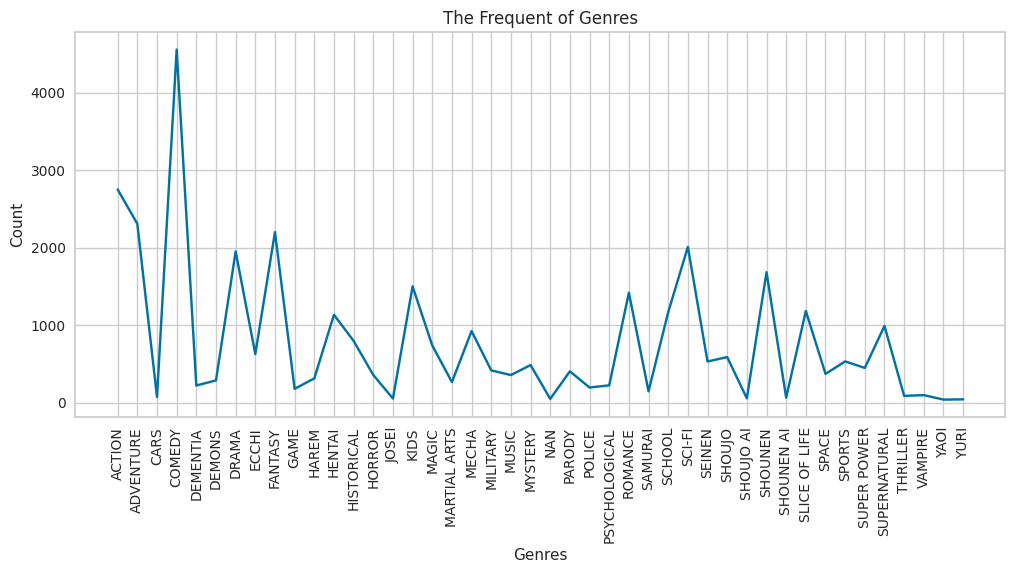

In [65]:
# get the most frequent Genre in Anime dataset
freqGenre = pd.DataFrame(data=[(genres.columns[i], genres.iloc[:,i].value_counts().iloc[-1]) for i in range(44)]).set_index(0)
freqGenre.sort_values(by=1, ascending=False)
plt.figure(figsize=(12,5))
plt.plot(freqGenre)
plt.title('The Frequent of Genres'); plt.xlabel('Genres'); plt.ylabel('Count')
plt.xticks(rotation=90); plt.show()

# note: comedy is the most frequent genre, this may indicate that most recommended anime have comedy genre

In [66]:
# if we take a closer look, we see that 'NAN' became it's own column

# looking into 'NAN' - 47 rows
pd.set_option('display.max_columns', None)
display(genres[genres.NAN == 1].head())
pd.reset_option('display.max_columns')

# note: we see that all other columns are 0 and only NAN is 1
# there are only 47 rows with 'NAN' genre, this is very small
# for now, I will keep this column

,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,GAME,HAREM,HENTAI,HISTORICAL,HORROR,JOSEI,KIDS,MAGIC,MARTIAL ARTS,MECHA,MILITARY,MUSIC,MYSTERY,NAN,PARODY,POLICE,PSYCHOLOGICAL,ROMANCE,SAMURAI,SCHOOL,SCI-FI,SEINEN,SHOUJO,SHOUJO AI,SHOUNEN,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
2844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3541,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
### let's take a look at what we're working with now ###

# anime_df - 11,576 rows
display(anime_df.head())

# user_df - 7,787,231 rows
display(user_df.head())

# the animes that user = 1 watched - 153 rows
display(user_df[user_df.user_id == 1].head())

# the animes that user = 2 watched - 3 rows
display(user_df[user_df.user_id == 2].head())

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


,user_id,anime_id,rating
153,2,11771,10
154,2,12189,-1
155,2,16417,-1


In [68]:
### for clustering, we want to focus on 'user_id' and 'genre' columns - lets merge these two ###

In [69]:
# copy anime_df
animes = anime_df.copy()
# drop everything except anime_id
animes.drop(['name', 'genre', 'type', 'episodes', 'rating', 'members'], axis=1, inplace=True)
# add the encoded genres
anime_genre = pd.concat([animes, genres], axis=1)

# result: the same dataset, but with genre one-hot encoded - 11,576 rows
display(anime_genre.head())

,anime_id,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
0,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,28977,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9253,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# copy user_df
users = user_df.copy()
# drop rating
users.drop(['rating'], axis=1, inplace=True)

# result: the same dataset, but without 'rating' column - 7,787,231 rows
display(users.head())

,user_id,anime_id
0,1,20
1,1,24
2,1,79
3,1,226
4,1,241


In [71]:
# merge these two datasets
merged_df = pd.merge(users, anime_genre, on='anime_id')

# result: user_id, anime_id, and genre columns - 7,787,221 rows
display(merged_df.head())

,user_id,anime_id,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
0,1,20,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,3,20,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,5,20,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,6,20,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,10,20,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [72]:
# lets take a look at what we're working with now

# the animes that user = 1 watched - 153 rows
display(merged_df[merged_df.user_id == 1].head())

# the animes that user = 2 watched - 3 rows
display(merged_df[merged_df.user_id == 2].head())

,user_id,anime_id,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
0,1,20,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
25925,1,24,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33078,1,79,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
40190,1,226,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
67696,1,241,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,user_id,anime_id,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
669272,2,11771,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1094617,2,12189,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1105140,2,16417,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [73]:
### Sample 50% of the data ###
# data size is too large, reduce it - 3,893,610 rows
merged_df = merged_df.sample(frac=0.5, random_state=42)
display(merged_df)

,user_id,anime_id,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
3749313,65696,19151,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
5473663,52661,1482,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5156524,13429,6637,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2113071,58844,550,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3517400,34365,2904,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4839570,56577,13391,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4315078,67493,1571,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3619872,39986,6811,1,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
701115,39836,13367,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# for clustering: focus on 'user_id' and 'genre' columns 
clustering_df = merged_df.copy()
clustering_df.drop(['anime_id'], axis=1, inplace=True)
display(clustering_df.head())

,user_id,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
3749313,65696,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5473663,52661,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5156524,13429,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2113071,58844,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3517400,34365,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [75]:
# get the sum of the genre preferences of each user
clustering_df = clustering_df.groupby('user_id').sum()

# result: the data is now condensed
# instead of a row per anime the user watched, we return it as one row
# each column is the sum of anime they watched with that genre
# this is so that every row has info for a unique user and their preferences
display(clustering_df.head())

,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,GAME,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
user_id,,,,,,,,,,,,,,,,,,,,,
1,41,8,0,50,0,6,13,33,24,3,...,0,2,0,1,8,30,0,2,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,29,22,0,23,0,3,18,2,23,3,...,0,4,0,4,5,11,0,1,0,0
4,16,8,0,15,0,1,2,2,11,1,...,0,2,0,1,3,7,1,2,0,0
5,70,55,3,157,1,8,47,44,50,7,...,0,37,4,22,20,45,3,1,0,0


In [76]:
# I will normalize the dataset using z-score normalization

scaler = StandardScaler()
clustering_norm = pd.DataFrame(scaler.fit_transform(clustering_df), columns = clustering_df.columns, index=clustering_df.index)

# result: a normalized dataset where the value indicates how often the genre occurs for each user - 71,600 rows
display(clustering_norm.head())

,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,GAME,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.601831,-0.229024,-0.212098,0.577551,-0.452410,1.072859,-0.086177,2.115008,0.520169,0.634604,...,-0.279105,-0.452141,-0.380273,-0.185302,0.344159,0.939461,-0.732611,0.172714,-0.191388,-0.150253
2,-0.750630,-0.707720,-0.212098,-0.668195,-0.452410,-0.685108,-0.770611,-0.534891,-0.741167,-0.629285,...,-0.279105,-0.611730,-0.380273,-0.185302,-0.735839,-0.791352,-0.732611,-0.676769,-0.191388,-0.150253
3,0.205989,0.608695,-0.212098,-0.108881,-0.452410,0.193876,0.177067,-0.374291,0.467613,0.634604,...,-0.279105,-0.292551,-0.380273,0.603484,-0.060840,-0.156721,-0.732611,-0.252027,-0.191388,-0.150253
4,-0.222840,-0.229024,-0.212098,-0.312268,-0.452410,-0.392113,-0.665314,-0.374291,-0.163055,-0.207989,...,-0.279105,-0.452141,-0.380273,-0.185302,-0.330840,-0.387496,-0.432106,0.172714,-0.191388,-0.150253
5,1.558449,2.583316,4.000832,3.297854,0.544438,1.658848,1.703882,2.998307,1.886617,2.319791,...,-0.279105,2.340675,0.841926,5.336204,1.964154,1.804868,0.168904,-0.252027,-0.191388,-0.150253


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

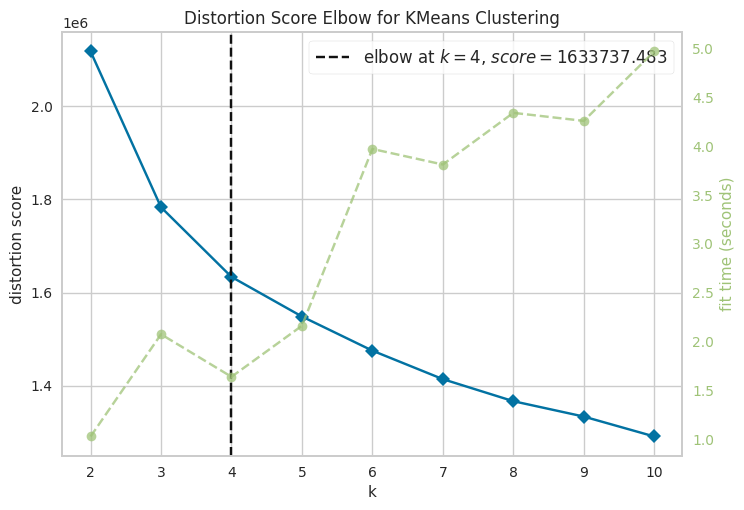

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
# Elbow Method
model = KMeans(random_state=42)
elbow = KElbowVisualizer(model,k=(2,11))
elbow.fit(clustering_norm)
elbow.show()

In [78]:
# calculate silhouette scores for different values of k
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(clustering_norm)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(clustering_norm, labels)
    silhouette_scores.append(silhouette_avg)

# determine the best value of k based on the silhouette scores
best_k = silhouette_scores.index(max(silhouette_scores)) + 2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

best k :  2
silhouette scores :  [0.6005350373823796, 0.471402055113881, 0.3684161058335036, 0.3667433829055593, 0.30863357984251594, 0.3092812109400514, 0.26278127098233556, 0.2511519155694982, 0.24834046994001754]


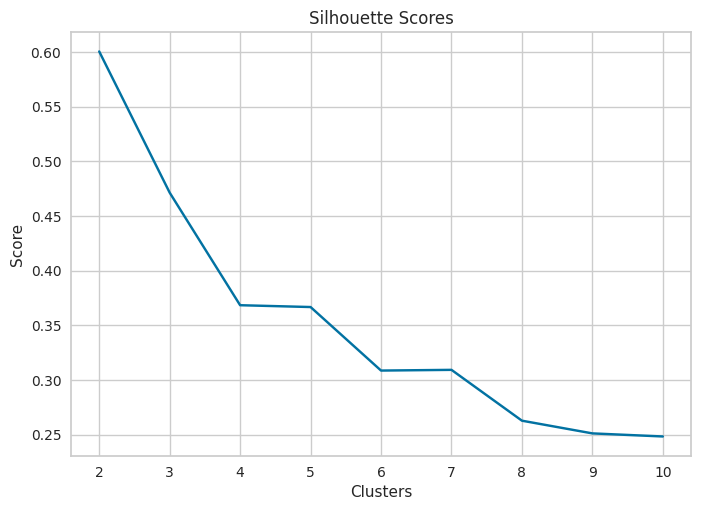

In [79]:
# the best k given by the silhoutte method and the corresponding silhouette scores from 2 to 10 clusters
print("best k : ", best_k)
print("silhouette scores : ", silhouette_scores)
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# plot the values as a line graph
plt.plot(k_values, silhouette_scores)

# add labels to the graph
plt.title("Silhouette Scores")
plt.xlabel("Clusters")
plt.ylabel("Score")

# show the plot
plt.show()

In [46]:
### evaluating best K results ###
# elbow method: 4 clusters
# silhouette method: 2 clusters
# what we want is a high silhouette score and a low distortion score
# after analyzing these results, I think a good balance between these two scores is at k = 4, so this is what I'll use

In [47]:
### apply KMeans clustering ###
# hyperparameters:
# number of clusters (n_clusters): I will set as best chosen k = 4
# initialization method (init): The default initialization method is k-means++.
# maximum number of iterations (max_iter): The default maximum number of iterations is set to 300.
# distance metric (metric): The default distance metric used is Euclidean distance.
# convergence tolerance (tol): The default value for the convergence tolerance is 1e-4.
# seed value (random_state): I will use 42, cross validation can be used to find the best random_state value

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(clustering_norm)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [48]:
# add cluster labels to the data
clustering_labels = clustering_norm.copy()
clustering_labels['cluster'] = kmeans.labels_

In [49]:
# take a look at the results: 71,600 rows
display(clustering_labels)

,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,GAME,...,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.601831,-0.229024,-0.212098,0.577551,-0.452410,1.072859,-0.086177,2.115008,0.520169,0.634604,...,-0.452141,-0.380273,-0.185302,0.344159,0.939461,-0.732611,0.172714,-0.191388,-0.150253,3
2,-0.750630,-0.707720,-0.212098,-0.668195,-0.452410,-0.685108,-0.770611,-0.534891,-0.741167,-0.629285,...,-0.611730,-0.380273,-0.185302,-0.735839,-0.791352,-0.732611,-0.676769,-0.191388,-0.150253,0
3,0.205989,0.608695,-0.212098,-0.108881,-0.452410,0.193876,0.177067,-0.374291,0.467613,0.634604,...,-0.292551,-0.380273,0.603484,-0.060840,-0.156721,-0.732611,-0.252027,-0.191388,-0.150253,0
4,-0.222840,-0.229024,-0.212098,-0.312268,-0.452410,-0.392113,-0.665314,-0.374291,-0.163055,-0.207989,...,-0.452141,-0.380273,-0.185302,-0.330840,-0.387496,-0.432106,0.172714,-0.191388,-0.150253,0
5,1.558449,2.583316,4.000832,3.297854,0.544438,1.658848,1.703882,2.998307,1.886617,2.319791,...,2.340675,0.841926,5.336204,1.964154,1.804868,0.168904,-0.252027,-0.191388,-0.150253,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73511,-0.717643,-0.588046,-0.212098,-0.541078,-0.452410,-0.685108,-0.770611,-0.454591,-0.688611,-0.629285,...,-0.452141,-0.380273,-0.448231,-0.735839,-0.733659,-0.732611,-0.676769,-0.191388,-0.150253,0
73512,-0.717643,-0.707720,-0.212098,-0.642772,-0.452410,-0.685108,-0.665314,-0.534891,-0.688611,-0.629285,...,-0.611730,-0.380273,-0.448231,-0.735839,-0.675965,-0.732611,-0.676769,-0.191388,-0.150253,0
73513,-0.585696,-0.468372,-0.212098,-0.464808,0.544438,-0.685108,-0.454719,-0.374291,-0.688611,-0.629285,...,-0.452141,0.230827,-0.185302,-0.735839,-0.560577,-0.732611,-0.252027,-0.191388,-0.150253,0


In [50]:
### evaluating the clusters ###

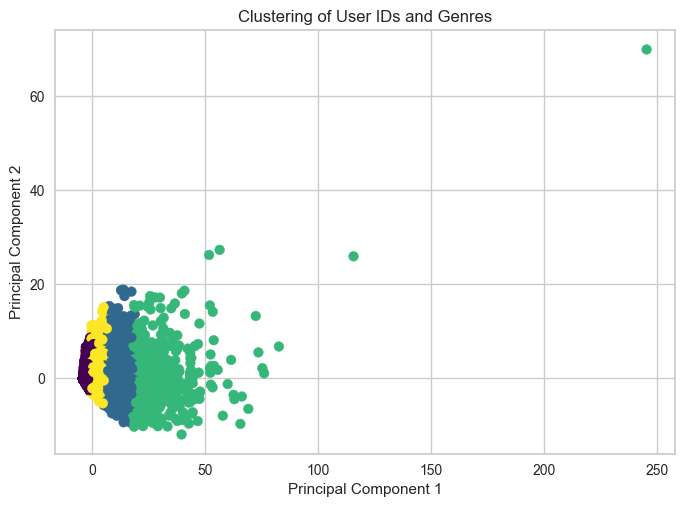

In [51]:
# plot the clusters

# apply PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(clustering_labels)

# plot the clusters using the reduced dimensions
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering of User IDs and Genres')
plt.show()

In [52]:
# from the above plot, it doesn't look like it is a good clustering
# all the cluster are very close together and may be too similar to each other

In [53]:
### for association rule mining, we want to focus on user_id and anime_id ###

In [54]:
# we want to identify which cluster each user belongs to

# get the cluster each user belongs to - 71,600 rows
user_cluster = clustering_labels[['cluster']]
display(user_cluster)

# all the users and the anime they watched - 3,893,610 rows
user_anime = merged_df[['user_id', 'anime_id']]
display(user_anime)

,cluster
user_id,
1,3
2,0
3,0
4,0
5,1
...,...
73511,0
73512,0
73513,0


,user_id,anime_id
3749313,65696,19151
5473663,52661,1482
5156524,13429,6637
2113071,58844,550
3517400,34365,2904
...,...,...
4839570,56577,13391
4315078,67493,1571
3619872,39986,6811
701115,39836,13367


In [55]:
# get the users and their anime and merge them on user_id with their cluster
merged_cluster = pd.merge(user_cluster, user_anime, left_index=True, right_on='user_id')

# 3,893,610 rows
display(merged_cluster)

# result: a dataframe with three attributes: cluster, user_id, anime_id
# each user has a cluster label

,cluster,user_id,anime_id
692726,3,1,12729
900308,3,1,20045
159516,3,1,2144
470219,3,1,9136
705118,3,1,13561
...,...,...,...
6187626,3,73515,3594
7329194,3,73515,860
5684537,3,73515,168
3706695,3,73515,12967


In [56]:
# lets see what we're working with - confirm the dataset is the same as before

# the animes that user = 1 watched - 78 rows
display(merged_cluster[merged_cluster.user_id == 1])

# the animes that user = 2 watched - 1 rows
display(merged_cluster[merged_cluster.user_id == 2])

,cluster,user_id,anime_id
692726,3,1,12729
900308,3,1,20045
159516,3,1,2144
470219,3,1,9136
705118,3,1,13561
...,...,...,...
785881,3,1,16498
986824,3,1,22663
832385,3,1,17729
1016051,3,1,24873


,cluster,user_id,anime_id
669272,0,2,11771


In [57]:
# create a copy of dataframe used for association rule mining - 3,893,610 rows
association_cluster = merged_cluster.copy()
display(association_cluster)

,cluster,user_id,anime_id
692726,3,1,12729
900308,3,1,20045
159516,3,1,2144
470219,3,1,9136
705118,3,1,13561
...,...,...,...
6187626,3,73515,3594
7329194,3,73515,860
5684537,3,73515,168
3706695,3,73515,12967


In [58]:
print('unique user_id: ',len(association_cluster.user_id.unique()))
print('unique anime_id: ',len(association_cluster.anime_id.unique()))

unique user_id:  71600
unique anime_id:  9896


In [72]:
# find association rules for each cluster based on user-anime viewing history
for cluster_label in np.unique(kmeans.labels_):
    
    # create binary matrix of user-anime watch history for current cluster
    cluster_data = association_cluster[association_cluster['cluster'] == cluster_label].drop('cluster', axis=1)
    watch_history = cluster_data.groupby(['user_id', 'anime_id']).size().unstack(fill_value=0)
    
    # convert matrix to transaction list
    transaction_list = watch_history.apply(lambda x: list(x.index[x.astype(bool)]), axis=1).tolist()
    
    # encode transaction list into a boolean matrix
    te = TransactionEncoder()
    te_ary = te.fit_transform(transaction_list)
    association_df = pd.DataFrame(te_ary, columns=te.columns_)
    
    # find frequent itemsets
    frequent_itemsets = apriori(association_df, min_support=0.1, use_colnames=True)
    
    # print frequent itemsets for current cluster
    print(f"Frequent itemsets for cluster {cluster_label}:")
    print(frequent_itemsets)
    
    # generate association rules for cluster based on user-anime viewing history
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    
    # print results
    print("Association rules for Cluster", cluster_label)
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
    
### to make recommendations for each user -  ###
#     if not rules.empty:
        
#         print('dataframe is not empty')
            
#         # Loop through each user in the cluster
#         for user_id in cluster_data.index:

#             # Get the anime the user has already watched
#             watched_anime = cluster_data.loc[user_id, cluster_data.columns != 'cluster'].index[cluster_data.loc[user_id, cluster_data.columns != 'cluster'] != 0].tolist()

#             # Apply the association rules to the user's watch history to get recommended anime
#             recommendations = rules[rules['antecedents'].apply(lambda x: set(watched_anime).issubset(set(x)))]['consequents'].tolist()

#             # Flatten the list of recommended anime
#             recommendations = [item for sublist in recommendations for item in sublist]

#             # Remove the anime the user has already watched from the recommendations
#             recommendations = list(set(recommendations) - set(watched_anime))
            
#             if recommendations:
#                 # Print the recommendations for the user
#                 print(f"Cluster {cluster_label}, User {user_id}: {recommendations}")

Frequent itemsets for cluster 0:
    support itemsets
0  0.132229     (20)
1  0.116736    (121)
2  0.110306    (199)
3  0.126100    (226)
4  0.218173   (1535)
5  0.117534   (1575)
6  0.107285   (5114)
7  0.119670   (6547)
8  0.150462  (11757)
9  0.144226  (16498)
Association rules for Cluster 0
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []
Frequent itemsets for cluster 1:
       support        itemsets
0     0.251863             (1)
1     0.139366             (5)
2     0.207835             (6)
3     0.107298            (19)
4     0.306292            (20)
...        ...             ...
1529  0.103484  (28121, 19815)
1530  0.110591  (30276, 19815)
1531  0.103657  (20507, 22319)
1532  0.104871  (27899, 22319)
1533  0.100711  (30276, 22319)

[1534 rows x 2 columns]
Association rules for Cluster 1
     antecedents consequents   support  confidence      lift
0            (1)      (1535)  0.111978    0.444597  1.094233
1         (1535)         (1)  0

KeyboardInterrupt: 

In [ ]:
# Use cross-validation to evaluate the quality of the clustering
X_train, X_test = train_test_split(clustering_labels, test_size=0.2, random_state=42)
kmeans_cv = KMeans(n_clusters=4, random_state=42)
cv_scores = cross_val_score(kmeans_cv, X_train.drop('cluster', axis=1), X_train['cluster'], cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean score: {np.mean(cv_scores)}')

In [ ]:
### evaluation ###
# these scores indicate that the KMeans clustering algorithm may not be performing very well on my dataset, 
# as the values of negative inertia are quite high. This suggests that the clusters are not very well-separated or compact. 
# I may want to try different clustering algorithms or adjust the parameters of the KMeans algorithm to improve the clustering performance.